In [1]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



In [2]:
library(ggplot2)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




In [3]:
library("clustree")

Loading required package: ggraph



In [4]:

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [5]:
normal.data <- Read10X(data.dir = "./filtered_gene_pAL_PC_1")
normal <- CreateSeuratObject(counts = normal.data, project = "pALPC1", min.cells = 3, min.features = 100)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [6]:
normal

An object of class Seurat 
15284 features across 4327 samples within 1 assay 
Active assay: RNA (15284 features, 0 variable features)

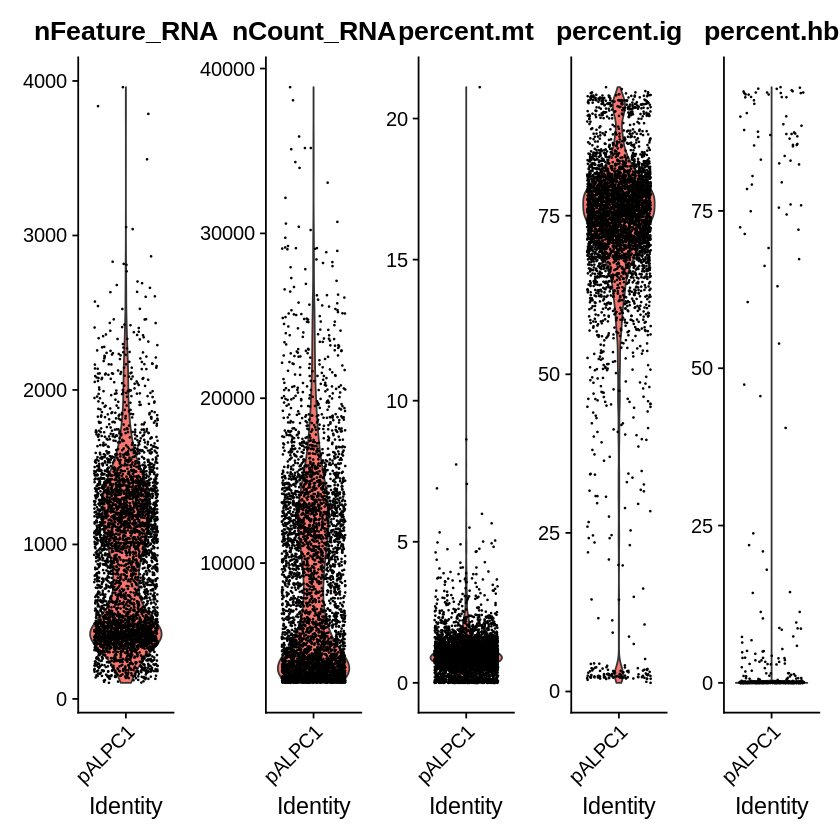

In [7]:
normal[["percent.mt"]] <- PercentageFeatureSet(normal, pattern = "^MT-")
normal[["percent.ig"]] <- PercentageFeatureSet(normal, pattern = "^IG")
normal[["percent.hb"]] <- PercentageFeatureSet(normal, pattern = "^HB")
VlnPlot(normal, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.ig","percent.hb"), ncol = 5)

In [8]:
summary(normal@meta.data)

  orig.ident     nCount_RNA     nFeature_RNA      percent.mt     
 pALPC1:4327   Min.   : 2738   Min.   : 104.0   Min.   : 0.0000  
               1st Qu.: 3821   1st Qu.: 442.0   1st Qu.: 0.6489  
               Median : 7473   Median : 915.0   Median : 0.9419  
               Mean   : 8966   Mean   : 919.7   Mean   : 1.0151  
               3rd Qu.:13035   3rd Qu.:1288.0   3rd Qu.: 1.2804  
               Max.   :38870   Max.   :3960.0   Max.   :21.1119  
   percent.ig       percent.hb      
 Min.   : 1.365   Min.   : 0.00000  
 1st Qu.:70.358   1st Qu.: 0.03079  
 Median :75.289   Median : 0.04789  
 Mean   :72.737   Mean   : 1.43322  
 3rd Qu.:79.345   3rd Qu.: 0.06779  
 Max.   :95.264   Max.   :94.66796  

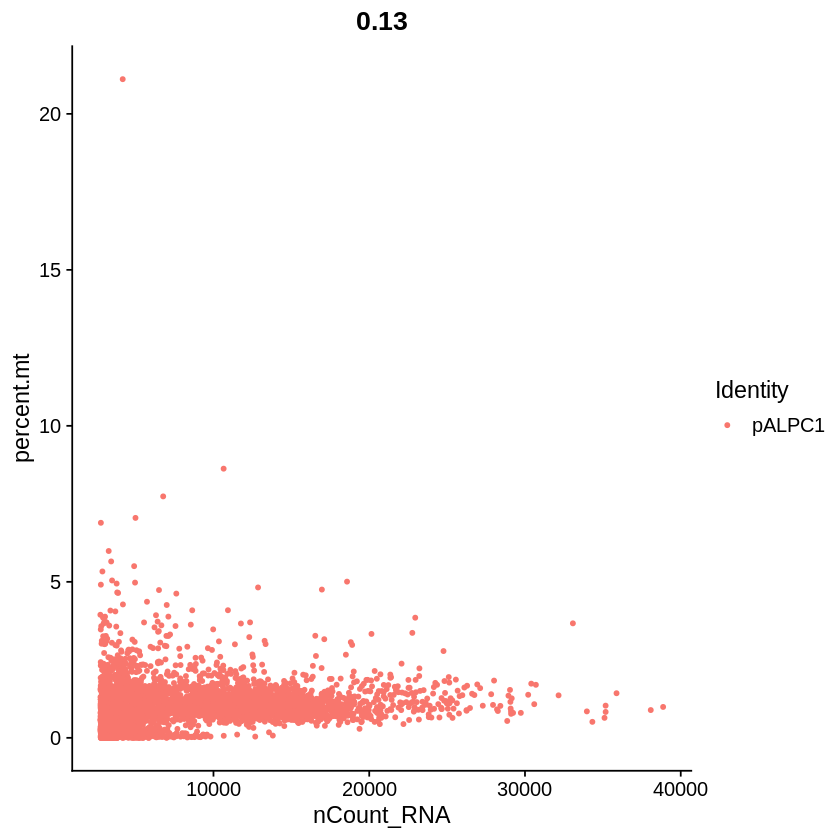

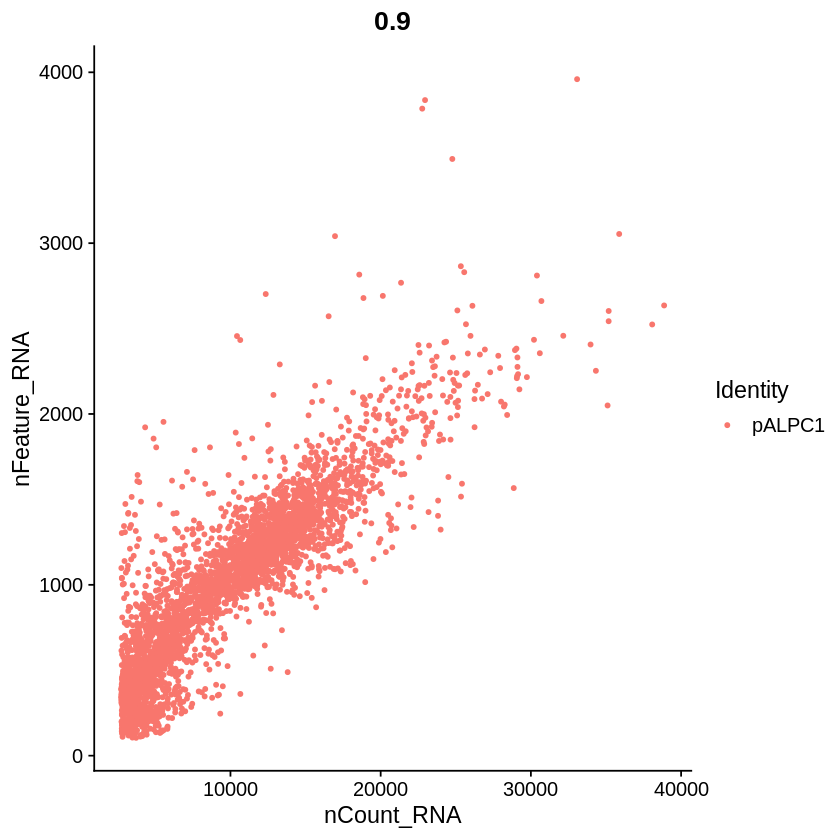

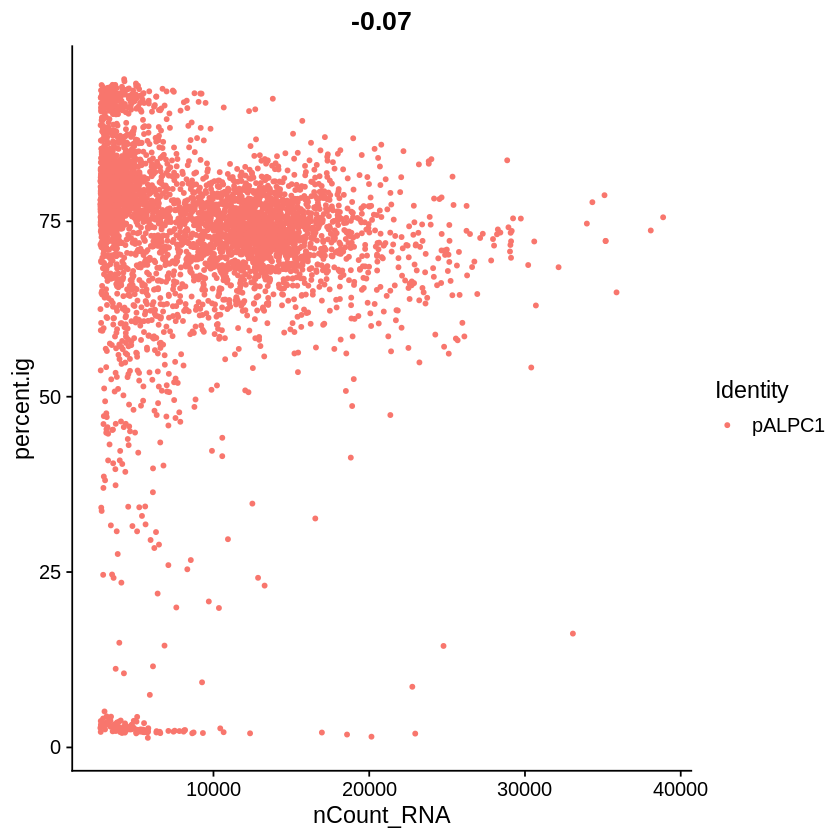

In [9]:
plot1 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot3 <- FeatureScatter(normal, feature1 = "nCount_RNA", feature2 = "percent.ig")
plot1
plot2
plot3

In [10]:
normal <- subset(normal, subset = nFeature_RNA > 100 & nFeature_RNA < 2500 & percent.mt < 5 & percent.hb < 1)
normal

An object of class Seurat 
15284 features across 4171 samples within 1 assay 
Active assay: RNA (15284 features, 0 variable features)

In [11]:
normal <- NormalizeData(normal, normalization.method = "LogNormalize", scale.factor = 10000)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 22 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 22 rows containing missing values (geom_point).”


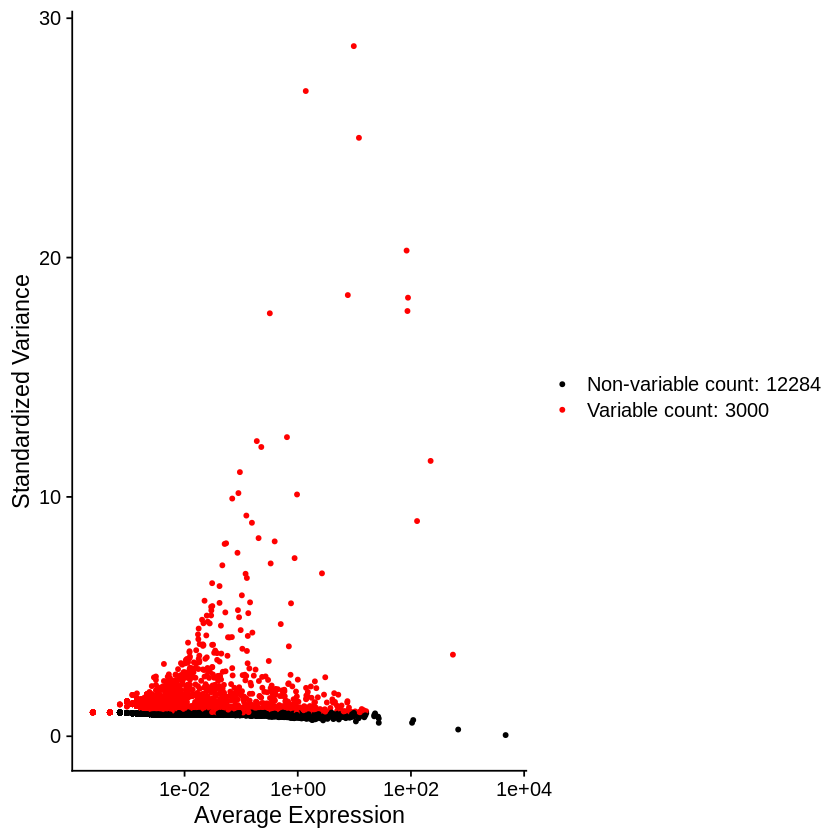

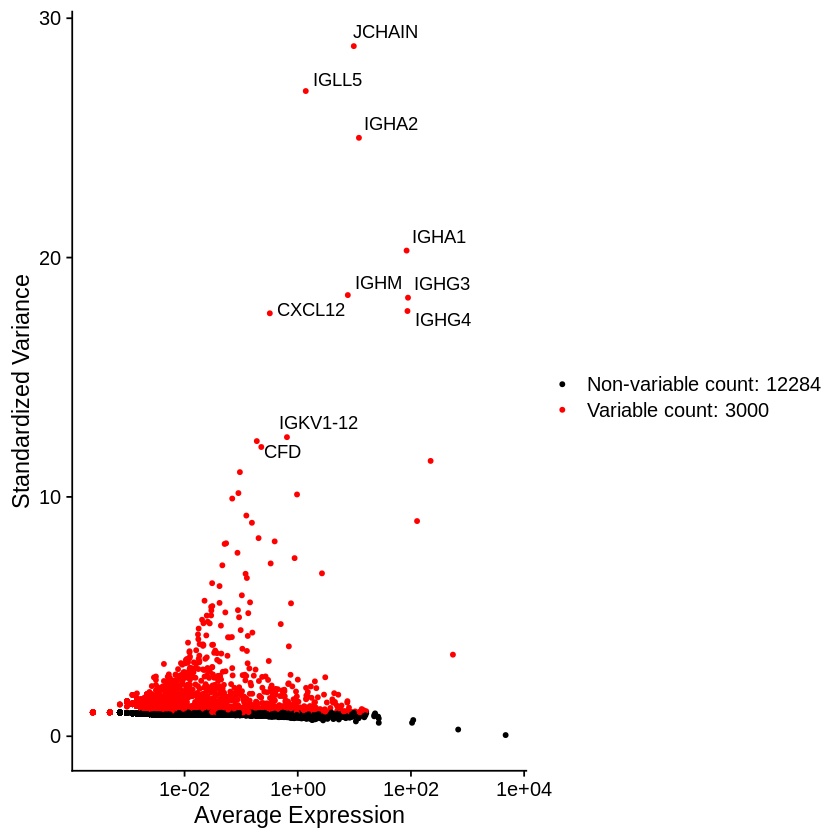

In [12]:
normal <- FindVariableFeatures(normal, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [13]:
all.genes <- rownames(normal)
normal <- ScaleData(normal, features = all.genes)

Centering and scaling data matrix



In [14]:
length(VariableFeatures(object = normal))

[1] 3000

In [15]:
normal <- RunPCA(normal, features = VariableFeatures(object = normal))

PC_ 1 
Positive:  IGLC2, MZB1, IGHG1, IGHV1-24, DERL3, B4GALT1, CST6, IGHG4, IGHG3, CTSW 
	   IGLC7, PHKG1, TNFRSF17, AHSP, LRRC16A, SAMD12, DHRS9, AREG, RP11-598F7.3, MGAT4C 
	   IGLC6, RP11-731F5.2, CA1, IGHV3-20, IGLV3-27, KIAA1217, IGHV3-13, CLIC2, ETV5, MSLN 
Negative:  IFITM3, CFD, HLA-DRB1, IFITM2, HLA-DRA, LY6E, CXCL12, APOE, VCAN, TAGLN 
	   IGFBP7, GSN, MT2A, TMEM176B, VCAM1, LPL, TF, SOX4, CALD1, LUM 
	   TNFAIP6, LEPR, COL1A2, OLFML3, TFPI, PCOLCE, ESM1, SERPINF1, CP, DCN 
PC_ 2 
Positive:  MT-CO1, MT-CO3, MT-ND1, EEF1A1, RPL3, RPS18, RPL18A, RPL7A, RPL28, TPT1 
	   RPS2, RPS19, RPS5, RPS4X, RPL13, GNB2L1, EEF1B2, XBP1, HERPUD1, KLF2 
	   SLC25A6, PTMA, ITM2C, HSP90B1, EEF2, ISG20, RPS24, KLF6, ERGIC3, FTL 
Negative:  CXCL12, APOE, IGFBP7, VCAN, LUM, LEPR, TF, VCAM1, LPL, OLFML3 
	   ESM1, DCN, CP, TNFAIP6, COL1A2, TFPI, TAGLN, CALD1, PTRF, GSN 
	   ANGPTL4, CCDC80, TPM2, CFH, LHFP, CYP1B1, PCOLCE, NNMT, GGT5, SERPINF1 
PC_ 3 
Positive:  TYROBP, COTL1, FCER1G, AIF1, LST1, C

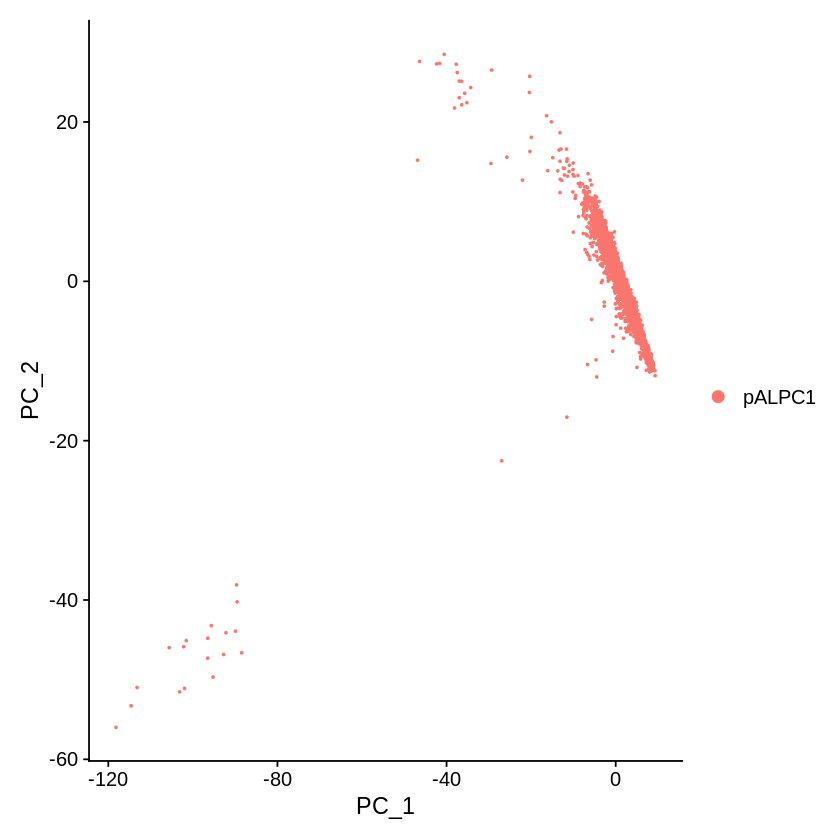

In [16]:
DimPlot(normal, reduction = "pca")

In [17]:
normal <- JackStraw(normal, num.replicate = 100)
normal <- ScoreJackStraw(normal, dims = 1:20)

Warning message:
“Removed 42022 rows containing missing values (geom_point).”


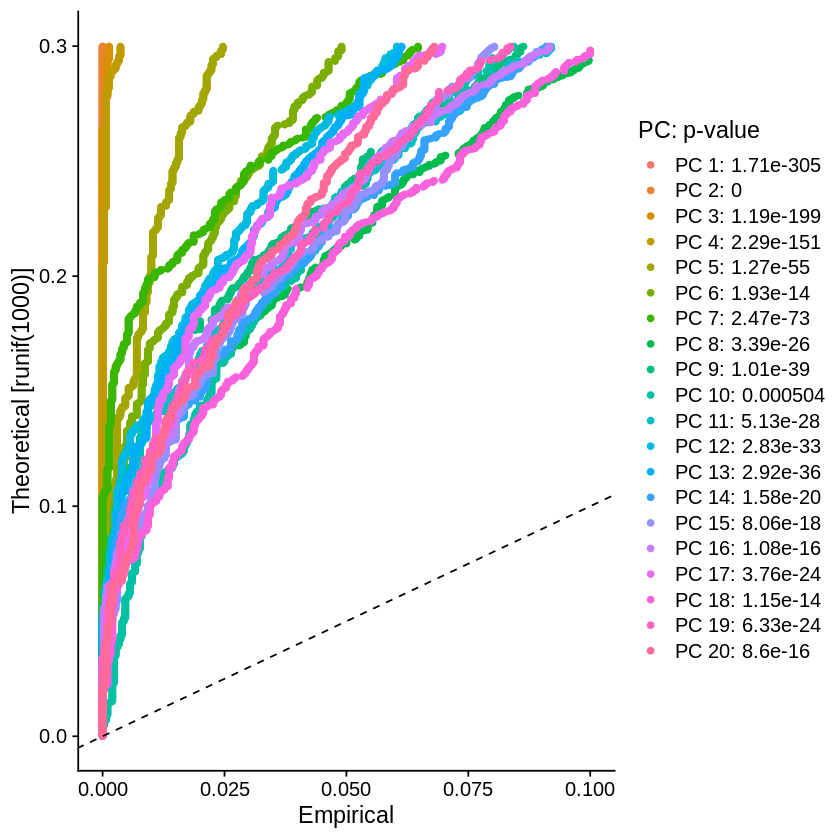

In [18]:
JackStrawPlot(normal, dims = 1:20)

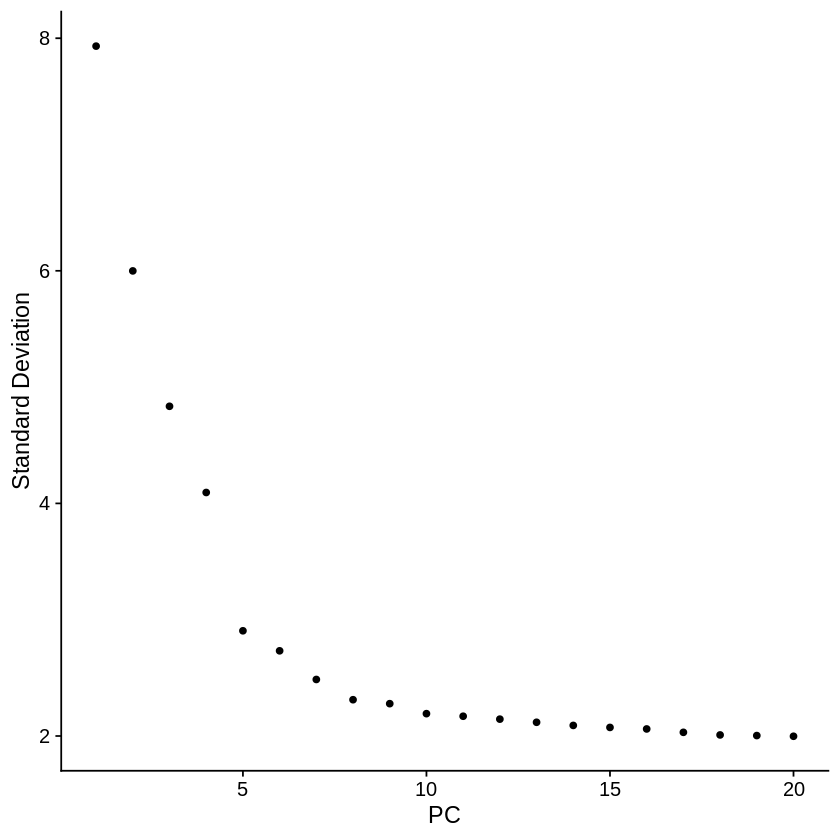

In [19]:
ElbowPlot(normal)

In [20]:
normal <- RunUMAP(normal, dims = 1:8)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:42:48 UMAP embedding parameters a = 0.9922 b = 1.112

13:42:48 Read 4171 rows and found 8 numeric columns

13:42:48 Using Annoy for neighbor search, n_neighbors = 30

13:42:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:42:49 Writing NN index file to temp file /tmp/RtmpMnPXbO/file82b006d659e4c

13:42:49 Searching Annoy index using 1 thread, search_k = 3000

13:42:50 Annoy recall = 100%

13:42:50 Commencing smooth kNN distance calibration using 1 thread

13:42:51 Initializing fro

In [21]:
options(repr.plot.height=8,repr.plot.width=8)

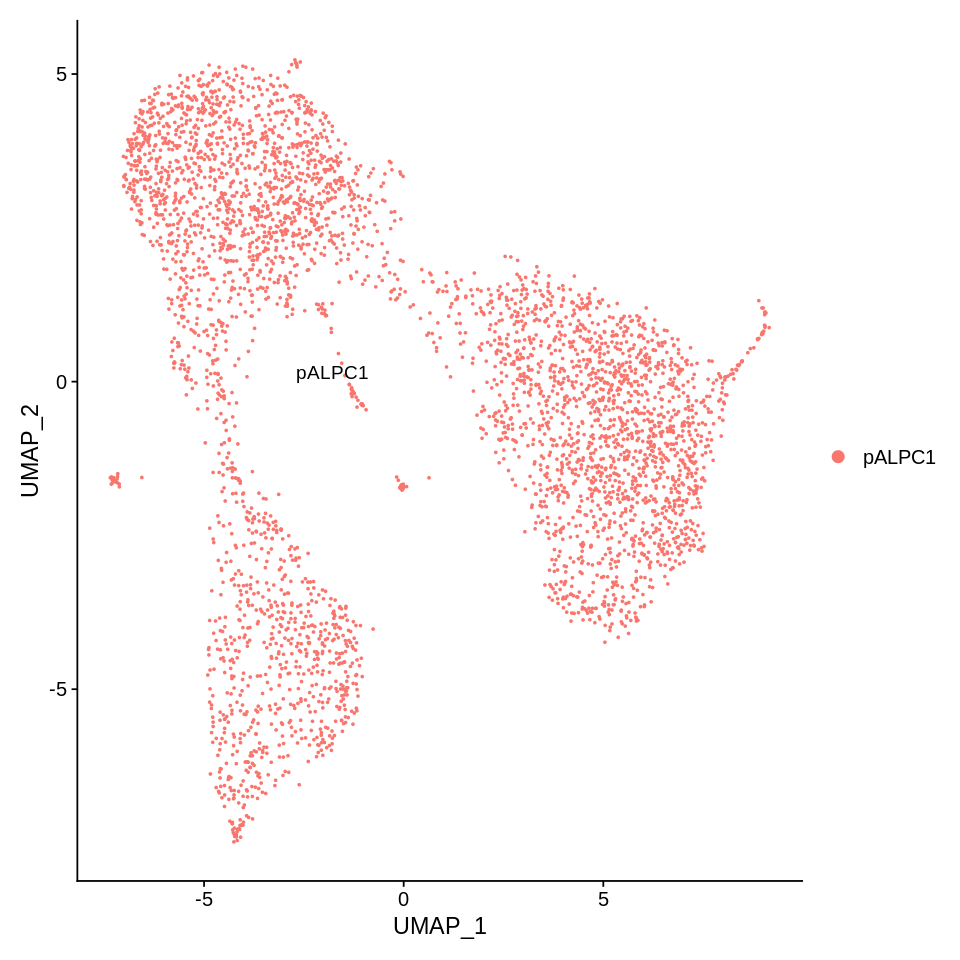

In [22]:
DimPlot(normal, reduction = "umap",label=T)

Loading required package: fields

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Loading required package: modes



NULL


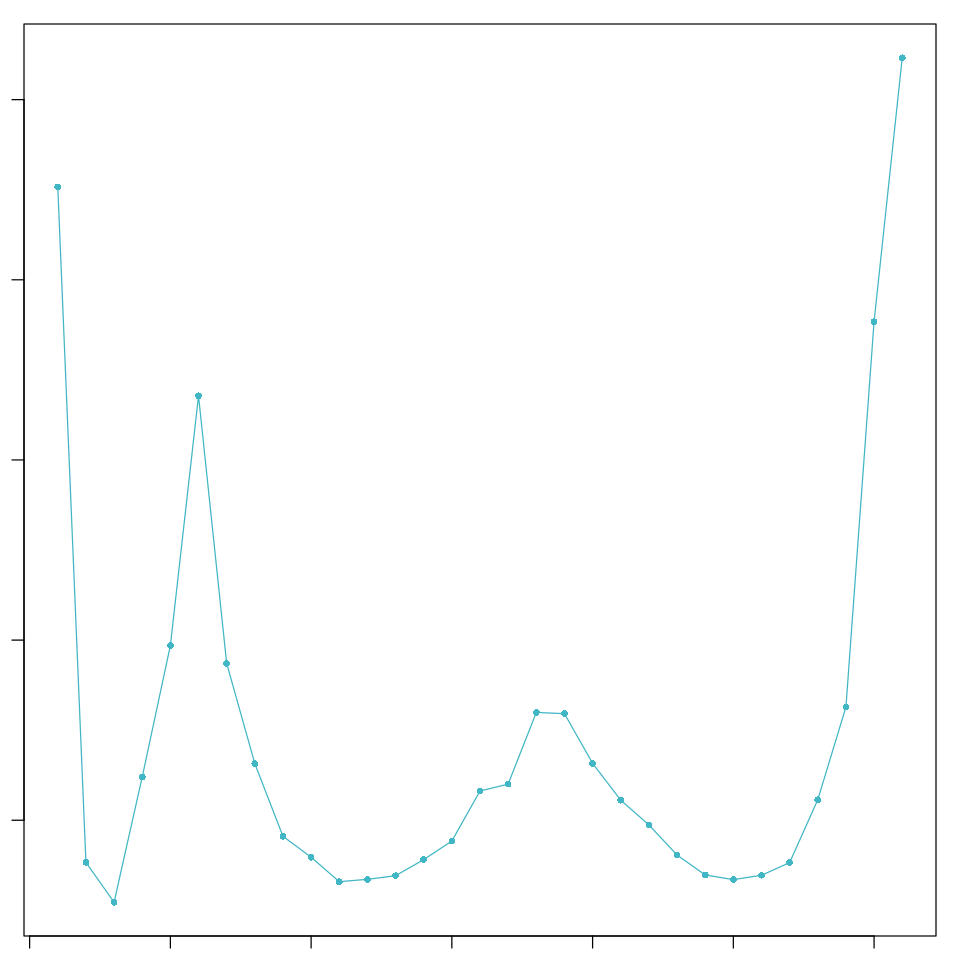

In [23]:
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(normal, PCs = 1:8, sct = FALSE)
for(i in 1:length(sweep.res.list)){
  if(length(sweep.res.list[[i]]$pANN[is.nan(sweep.res.list[[i]]$pANN)]) != 0){
    if(i != 1){
      sweep.res.list[[i]] <- sweep.res.list[[i - 1]]
    }else{
      sweep.res.list[[i]] <- sweep.res.list[[i + 1]]
    }
  }
}
sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn <- find.pK(sweep.stats)
pk_v <- as.numeric(as.character(bcmvn$pK))
pk_good <- pk_v[bcmvn$BCmetric==max(bcmvn$BCmetric)]
nExp_poi <- round(0.1*length(colnames(normal)))

In [24]:
normal <- doubletFinder_v3(normal, PCs = 1:8, pN = 0.25, pK = pk_good, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)

[1] "Creating 1390 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [25]:
colnames(normal@meta.data)[ncol(normal@meta.data)]="DoubletFinder"

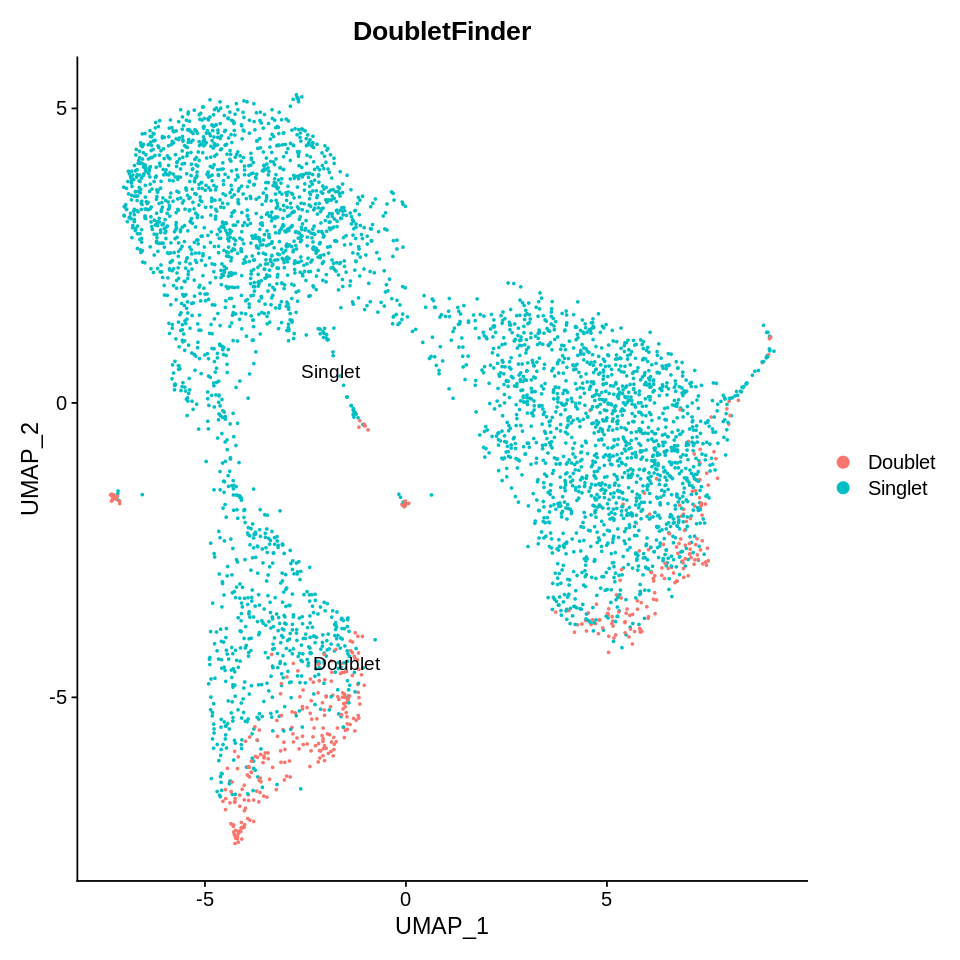

In [26]:
DimPlot(normal, reduction = "umap",label=T,group.by='DoubletFinder')

In [27]:
normal2<-subset(normal,DoubletFinder=='Singlet')

In [28]:
normal
normal2

An object of class Seurat 
15284 features across 4171 samples within 1 assay 
Active assay: RNA (15284 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
15284 features across 3754 samples within 1 assay 
Active assay: RNA (15284 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 127 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 127 rows containing missing values (geom_point).”


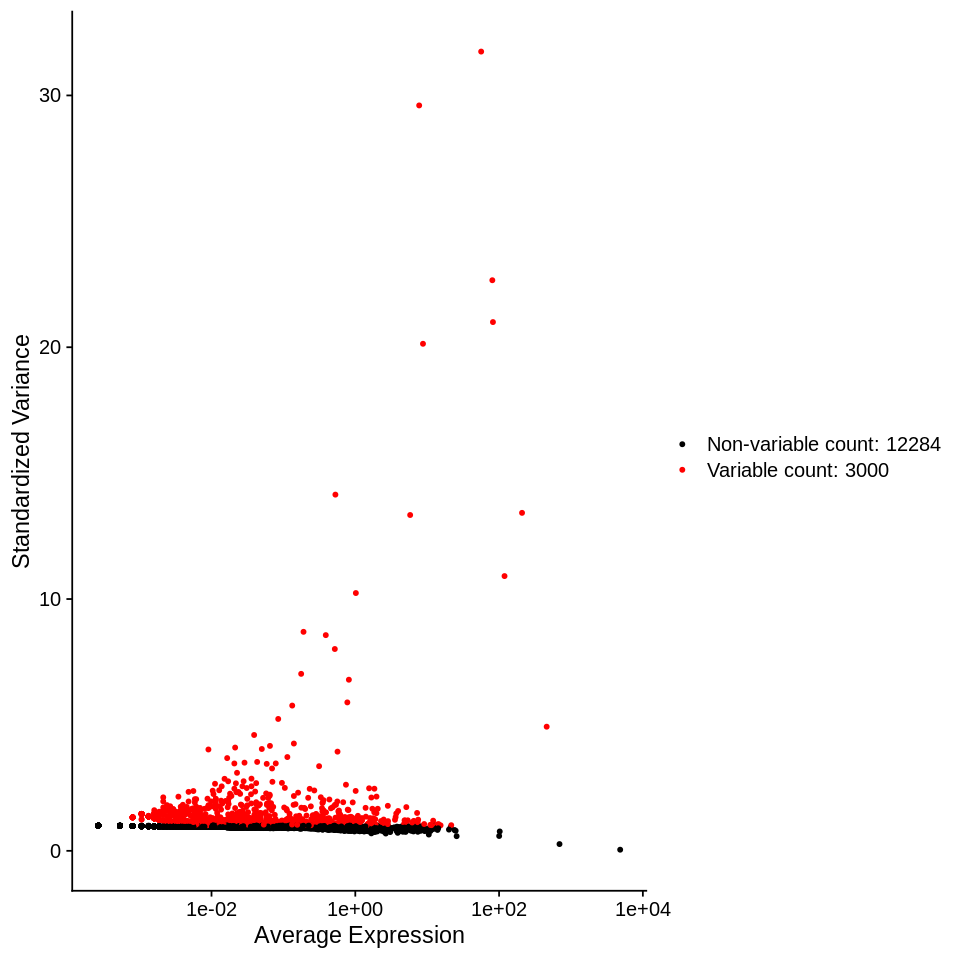

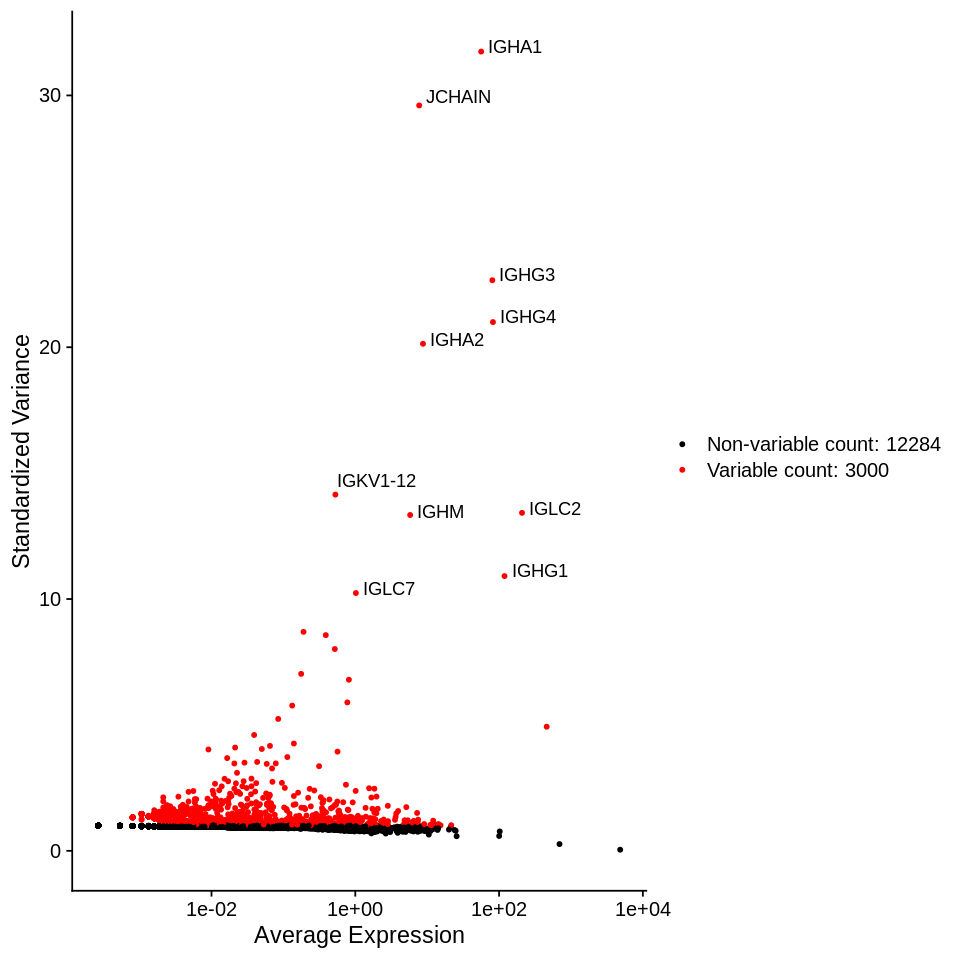

In [29]:
normal2 <- FindVariableFeatures(normal2, selection.method = "vst", nfeatures = 3000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(normal2), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(normal2)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1
plot2

In [30]:
all.genes <- rownames(normal2)
normal2 <- ScaleData(normal2, features = all.genes)

Centering and scaling data matrix



In [31]:
length(VariableFeatures(object = normal2))

[1] 3000

In [32]:
normal2 <- RunPCA(normal2, features = VariableFeatures(object = normal2))

PC_ 1 
Positive:  IGKC, IGHG1, IGHG4, JCHAIN, IGLC2, IGHG3, IGHA1, TMSB4X, PHKG1, IGKV4-1 
	   AIF1, S100A9, LRRC75A, FABP4, RNASE6, IGKV1-12, KLRB1, PPBP, B4GALT1, IGKV1-6 
	   TYROBP, IGHV3-30, MDM4, APOE, MSLN, HLA-DRA, IL32, HLA-DRB1, PF4, CD99 
Negative:  MT-CO1, MT-CO3, MT-ND1, MT-CYB, EEF1A1, RPL3, ZFP36L1, JUN, HLA-C, RPL7A 
	   FOS, KLF2, HLA-B, RPS2, JUNB, TPT1, BTG2, XBP1, ITM2C, HERPUD1 
	   MTDH, NEAT1, KLF6, TRIB1, FTL, H3F3B, ERGIC3, FOSB, MCL1, GLTSCR2 
PC_ 2 
Positive:  IGKC, IGHG1, IGHG4, CD79A, IGKV1-12, TMSB4X, RP5-887A10.1, IGHG3, TPT1, BTG1 
	   CD27, RPS4Y1, CTHRC1, JCHAIN, CECR1, DPEP1, CD9, VPREB3, AL928768.3, SPCS3 
	   EAF2, IL16, HIST1H4C, ITM2B, LSP1, CXCR4, ZFP36L2, PDK1, EIF1AY, HSP90B1 
Negative:  ZFP36L1, RP11-598F7.3, RHOB, S100A1, HSPB1, PPP1R14A, DHRS9, C1orf21, IGHV1-24, IGLC2 
	   NENF, PTP4A3, MCL1, METTL9, NGFRAP1, CFLAR, MOCOS, CCND2, CST6, S100A13 
	   JUNB, CTSH, FOS, PPIC, KRTCAP2, MTDH, IER2, TXNDC11, WBP5, RAB13 
PC_ 3 
Positive:  IFITM3, A

In [33]:
normal2 <- JackStraw(normal2, num.replicate = 100)
normal2 <- ScoreJackStraw(normal2, dims = 1:20)

Warning message:
“Removed 46490 rows containing missing values (geom_point).”


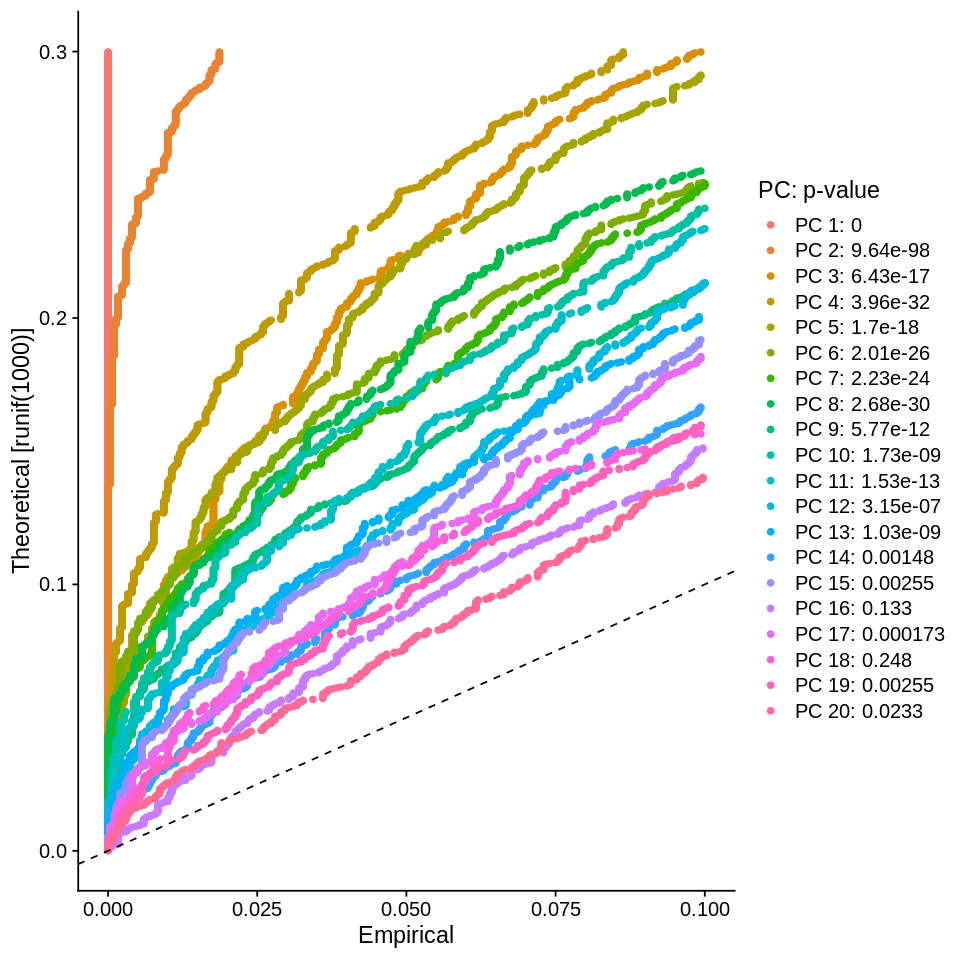

In [34]:
JackStrawPlot(normal2, dims = 1:20)

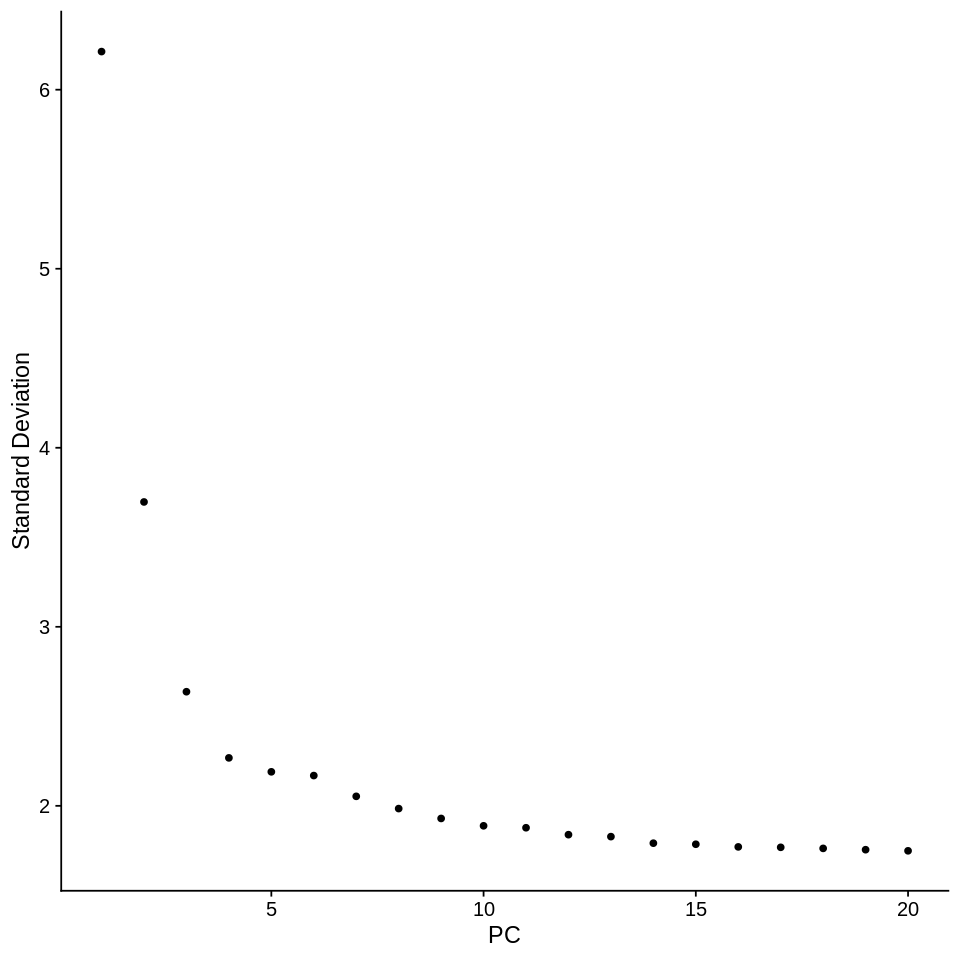

In [35]:
ElbowPlot(normal2)

In [36]:
normal2 <- FindNeighbors(normal2, dims = 1:15)
normal2 <- FindClusters(normal2, resolution = 1.2)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3754
Number of edges: 148387

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7355
Number of communities: 11
Elapsed time: 0 seconds


In [37]:
normal2 <- RunUMAP(normal2, dims = 1:15)

13:47:02 UMAP embedding parameters a = 0.9922 b = 1.112

13:47:02 Read 3754 rows and found 15 numeric columns

13:47:02 Using Annoy for neighbor search, n_neighbors = 30

13:47:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:47:03 Writing NN index file to temp file /tmp/RtmpMnPXbO/file82b0065a40d70

13:47:03 Searching Annoy index using 1 thread, search_k = 3000

13:47:04 Annoy recall = 100%

13:47:04 Commencing smooth kNN distance calibration using 1 thread

13:47:05 Initializing from normalized Laplacian + noise

13:47:05 Commencing optimization for 500 epochs, with 167926 positive edges

13:47:08 Optimization finished



In [38]:
options(repr.plot.height=8,repr.plot.width=8)

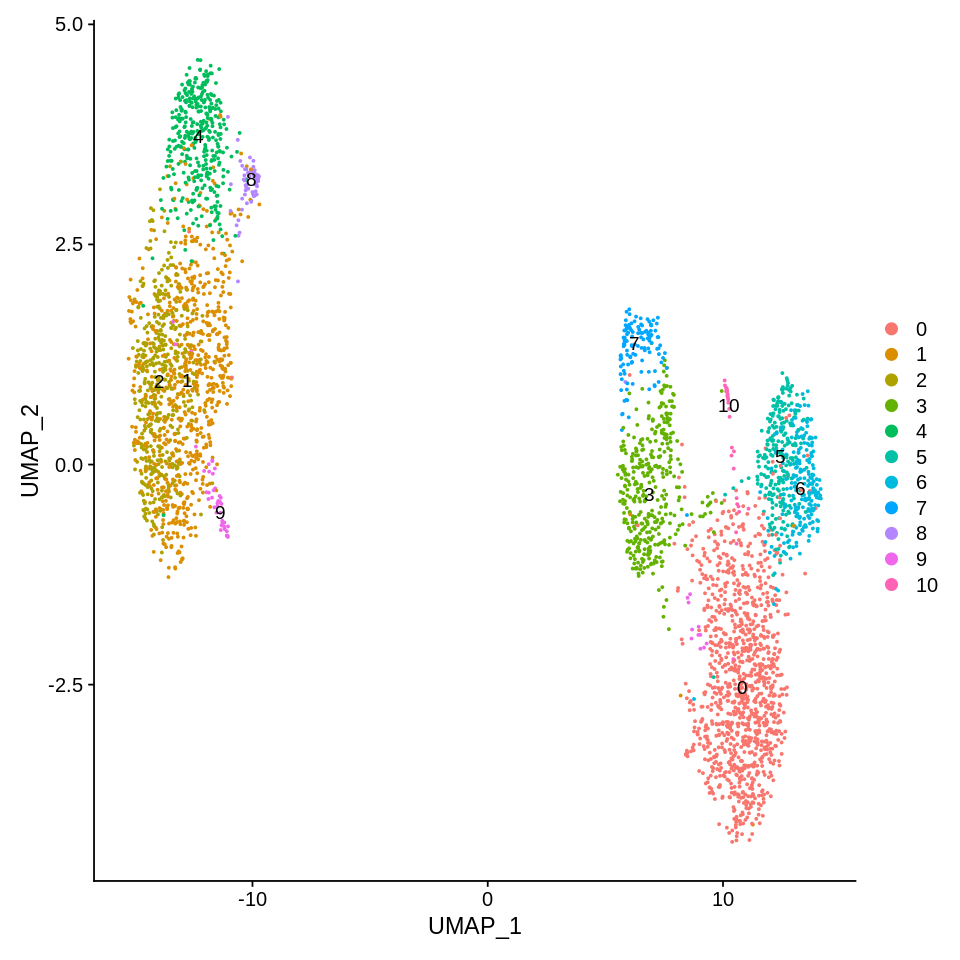

In [39]:
DimPlot(normal2, reduction = "umap",label=T)

In [40]:
options(repr.plot.height=9,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



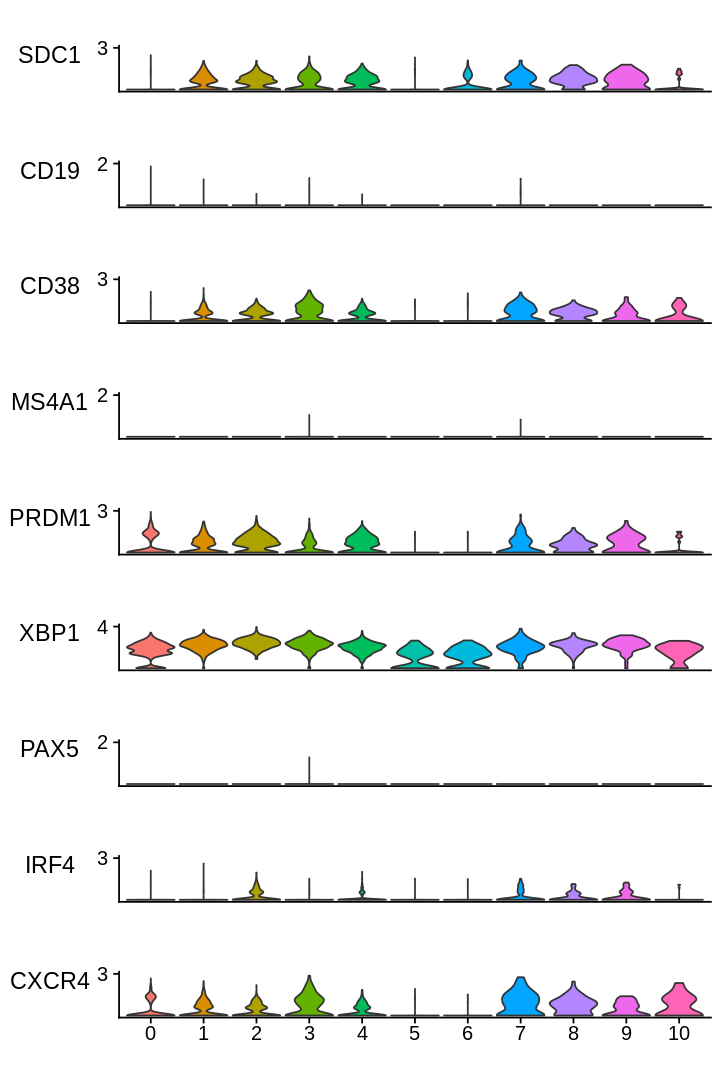

In [41]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



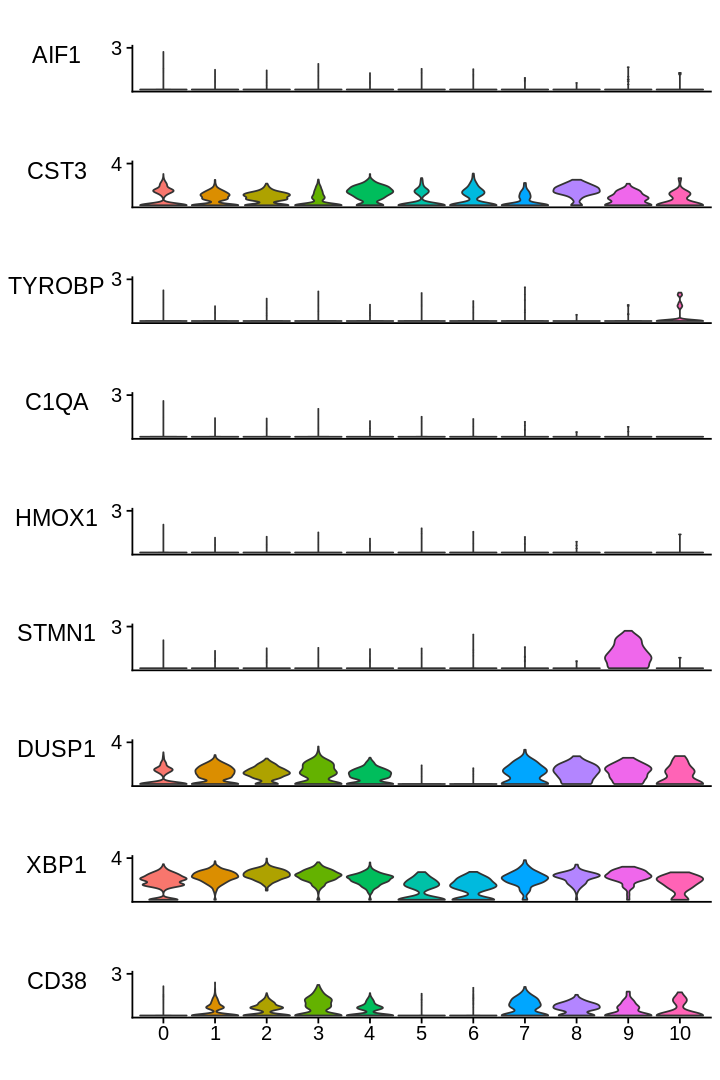

In [42]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =normal2, features = features)

In [43]:
options(repr.plot.height=6,repr.plot.width=6)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



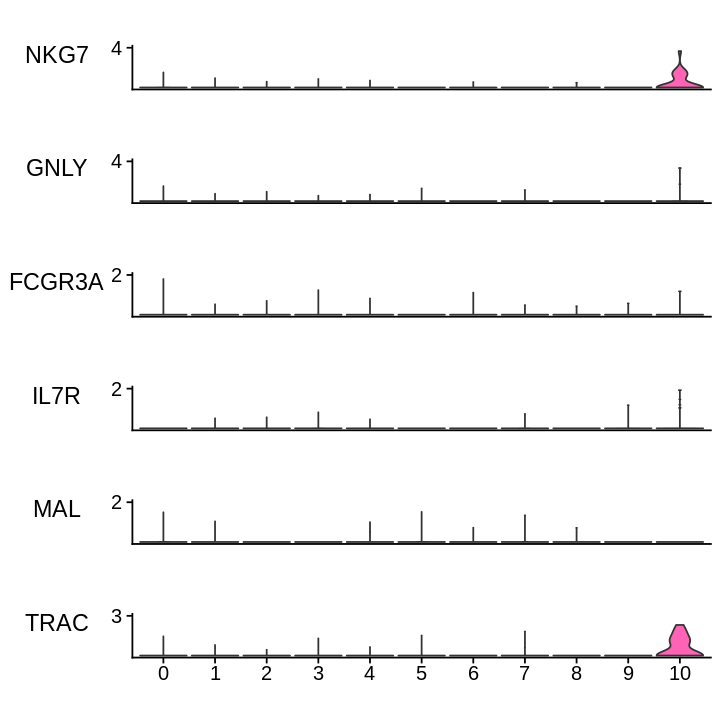

In [44]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =normal2, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



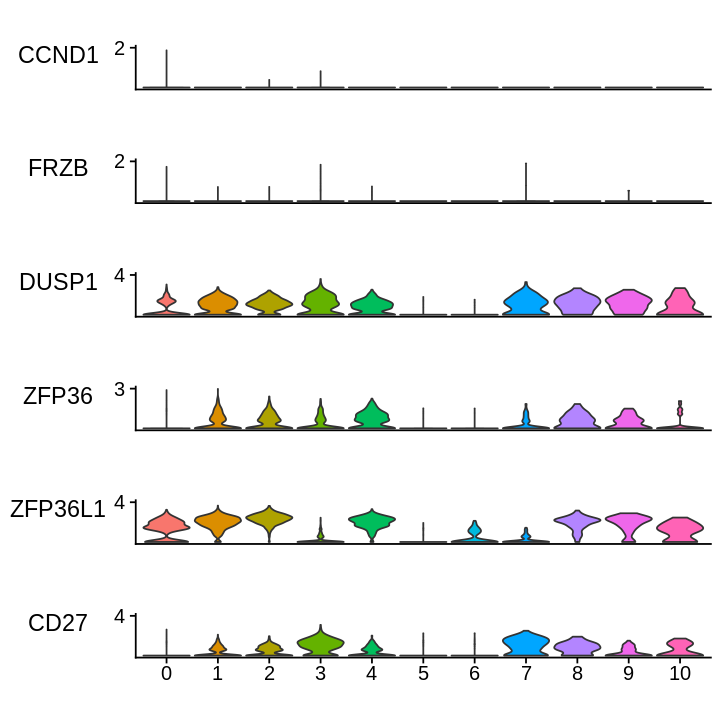

In [45]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =normal2, features = features)

In [46]:
options(repr.plot.height=4,repr.plot.width=8)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




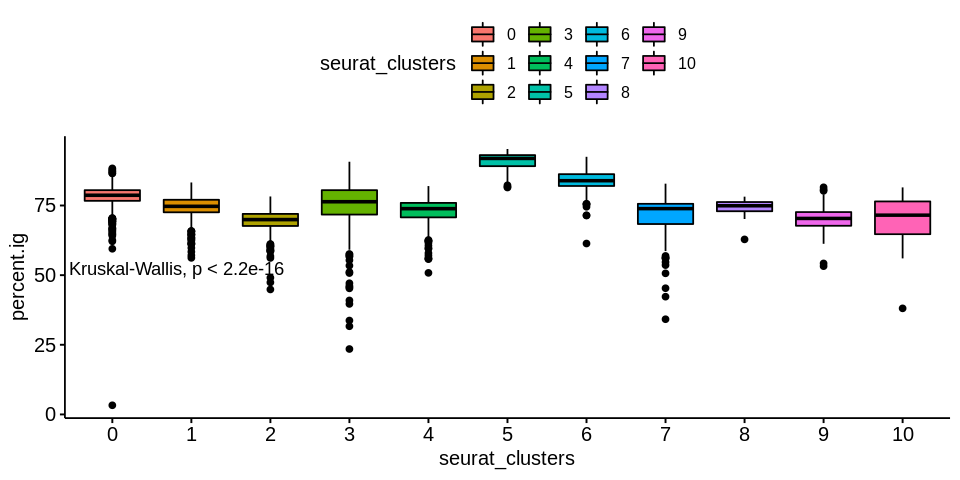

In [47]:
library(ggpubr)
library(RColorBrewer)
ggboxplot(normal2@meta.data, x="seurat_clusters", y="percent.ig", fill = "seurat_clusters")+
  stat_compare_means(label.y = 50)

In [48]:
normal3.markers <- FindAllMarkers(normal2, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
normal3.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.518894e-66,0.9921922,0.495,0.308,2.321478e-62,0,MDM4
9.171314e-44,0.8336967,0.495,0.385,1.401744e-39,0,HNRNPH1
2.185738e-34,0.8597355,0.439,0.321,3.340682e-30,0,B4GALT1
1.243626e-13,1.1379852,0.231,0.450,1.900758e-09,0,IGLC7
1.190527e-09,0.5668552,0.408,0.442,1.819602e-05,0,EIF5A
3.695277e-68,0.6942961,0.944,0.634,5.647861e-64,1,FOS
1.768731e-64,0.6220424,0.969,0.656,2.703328e-60,1,ZFP36L1
3.447803e-58,0.6960537,0.880,0.566,5.269621e-54,1,JUNB
1.575368e-55,0.6328335,0.971,0.781,2.407793e-51,1,JUN


In [49]:
options(repr.plot.height=10,repr.plot.width=10)

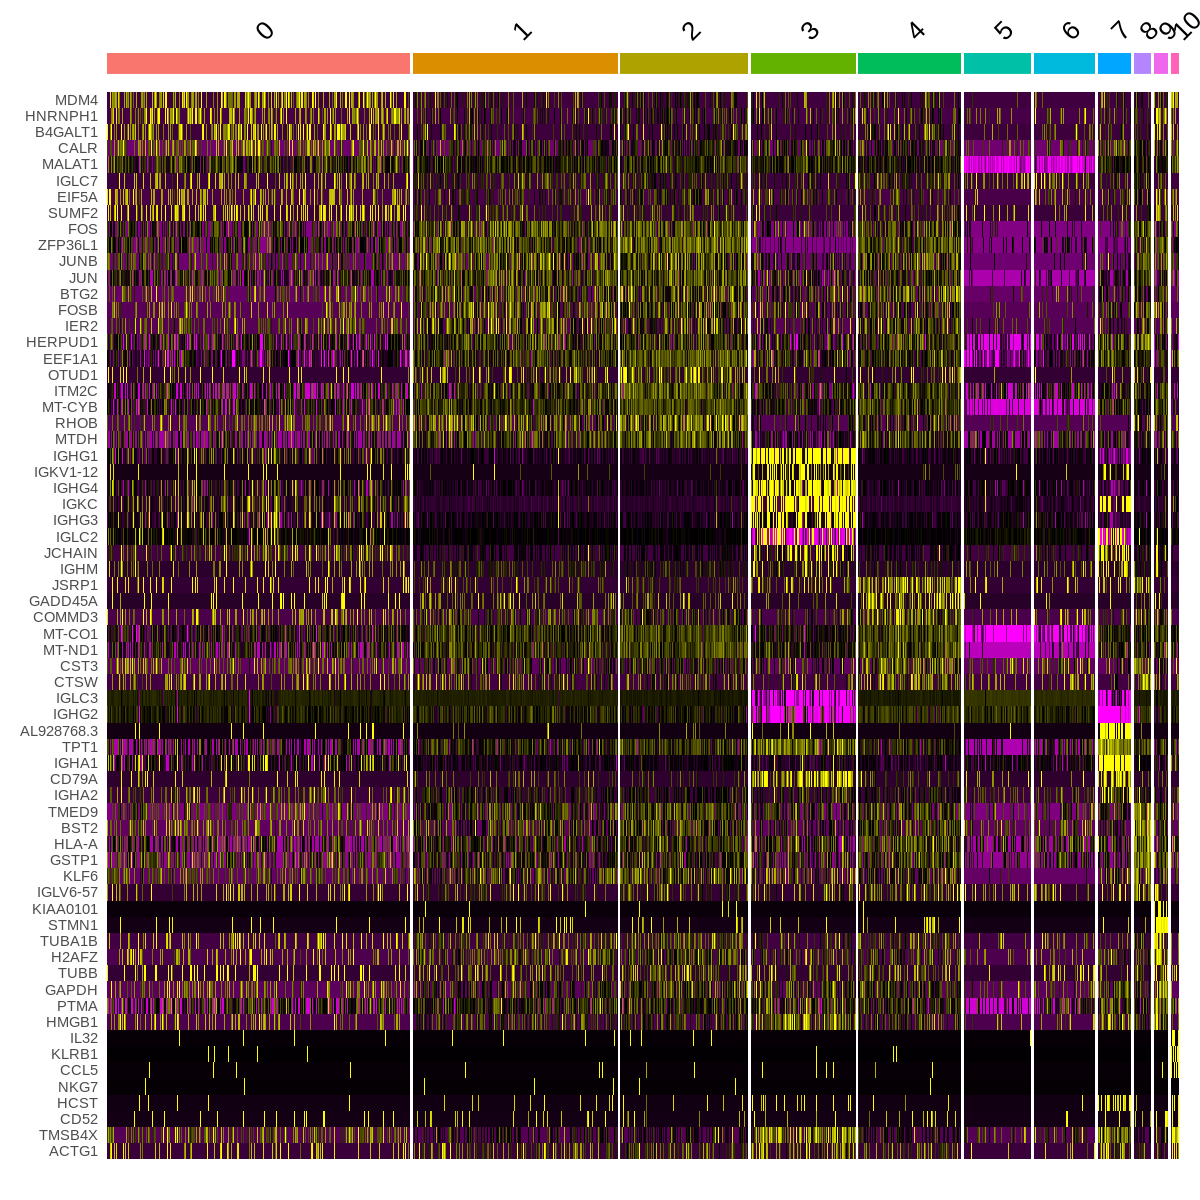

In [50]:
top10 <- normal3.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(normal2, features = top10$gene) + NoLegend()

In [51]:
library("Seurat")
library("SingleR")

In [52]:
counts<-normal2@assays$RNA@counts
clusters<-normal2@meta.data$seurat_clusters
ann=normal2@meta.data$orig.ident

In [53]:
singler = CreateSinglerObject(counts, annot = ann, "normal",
  species = "Human", citation = "",
  ref.list = list(), variable.genes = "de",
  fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
  reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 15284x3754"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3117"
[1] "Number of cells: 3754"
[1] "Number of DE genes:3117"
[1] "Number of clusters: 11"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:2420"
[1] "Number of cells: 3754"
[1] "Number of DE genes:2420"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:2949"
[1] "Number of cells: 3754"
[1] "Number of DE genes:2949"
[1] "Number of clusters: 11"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:2451"
[1] "Number of cells: 3754"
[1] "Number of DE genes:2451"
[1] "Number of clusters: 11"


In [54]:
singler$seurat = normal
singler$meta.data$xy = normal2@reductions$umap@cell.embeddings
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels
clusterAnn

0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,B-cells
7,B-cells
8,B-cells
9,B-cells
10,CD8+ T-cells


In [55]:
clusterAnn<-as.data.frame(clusterAnn)
clusterAnn

,V1
,<chr>
0,B-cells
1,B-cells
2,B-cells
3,B-cells
4,B-cells
5,B-cells
6,B-cells
7,B-cells
8,B-cells


In [56]:
type<-as.data.frame(singler$other)
type

,singler$other
,<chr>
AAACCTGAGGCCCTCA-1,CD14+ Monocytes
AAACCTGAGTTTGCGT-1,B cells
AAACCTGGTACGCTGC-1,CD14+ Monocytes
AAACCTGGTGAGTATA-1,NK cells
AAACCTGGTTATCACG-1,CD14+ Monocytes
AAACCTGGTTCCCGAG-1,B cells
AAACCTGTCAGAGACG-1,Dendritic cells
AAACCTGTCGTCACGG-1,CD14+ Monocytes
AAACGGGAGTTCCACA-1,B cells


In [57]:
count<-table(type)
count

type
          B cells   CD14+ Monocytes       CD4 T cells       CD8 T cells 
              974               560              1074                35 
  Dendritic cells FCGR3A+ Monocytes    Megakaryocytes          NK cells 
              376               314               332                89 

In [58]:
names<-as.vector(rownames(normal2@meta.data))
type2<-type[names,]

In [59]:
plasma<-subset(normal2,ident=c(0,1,2,3,4,5,6,7,8))

In [60]:
options(repr.plot.height=8,repr.plot.width=8)

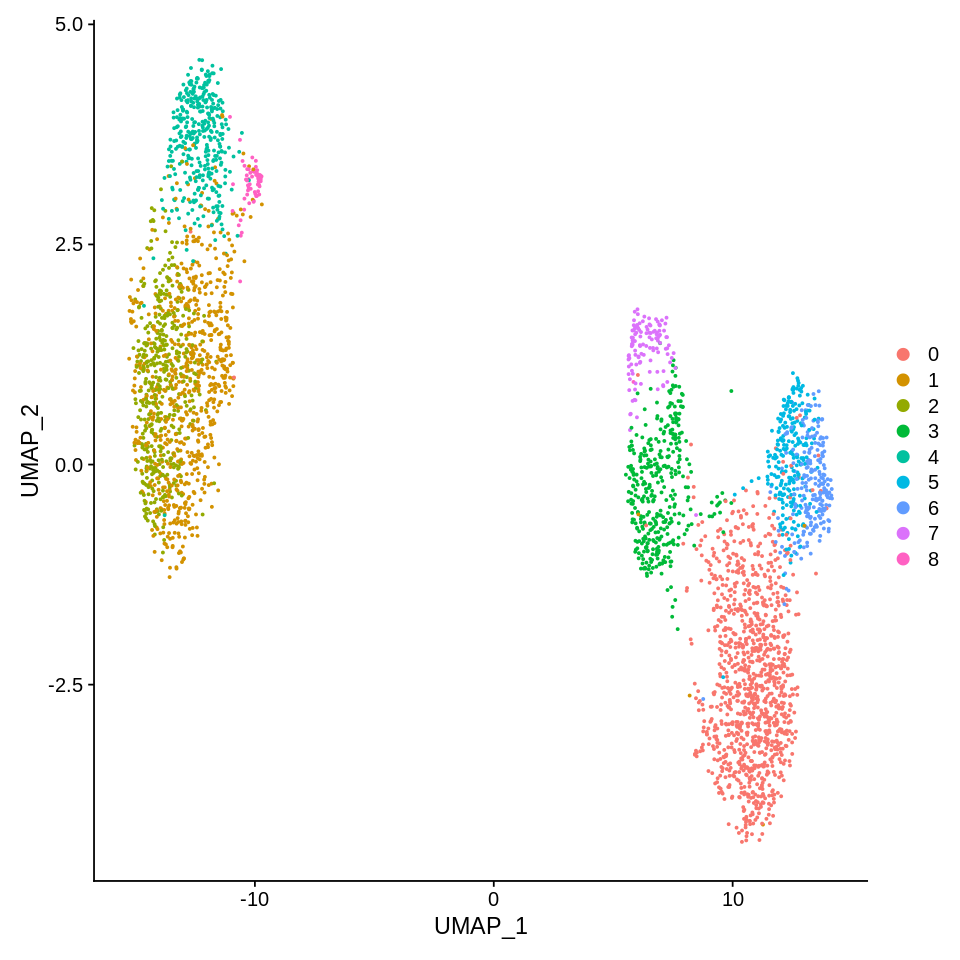

In [61]:
DimPlot(plasma, reduction = "umap")

In [62]:
plasma.markers <- FindAllMarkers(plasma, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
plasma.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
5.112181e-68,1.0085767,0.495,0.304,7.813457e-64,0,MDM4
2.160017e-46,0.8675074,0.495,0.378,3.301369e-42,0,HNRNPH1
2.883675e-35,0.8745813,0.439,0.318,4.407409e-31,0,B4GALT1
1.048609e-18,0.5549155,0.998,0.959,1.602694e-14,0,MALAT1
2.960246e-18,0.5583910,0.578,0.673,4.524439e-14,0,CALR
7.713661e-14,1.1299153,0.231,0.452,1.178956e-09,0,IGLC7
5.608991e-10,0.5788708,0.408,0.440,8.572781e-06,0,EIF5A
2.257879e-09,0.3188187,0.843,0.841,3.450942e-05,0,MT-ND3
5.791263e-09,0.5690655,0.323,0.309,8.851367e-05,0,SUMF2


In [63]:
options(repr.plot.height=8,repr.plot.width=8)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



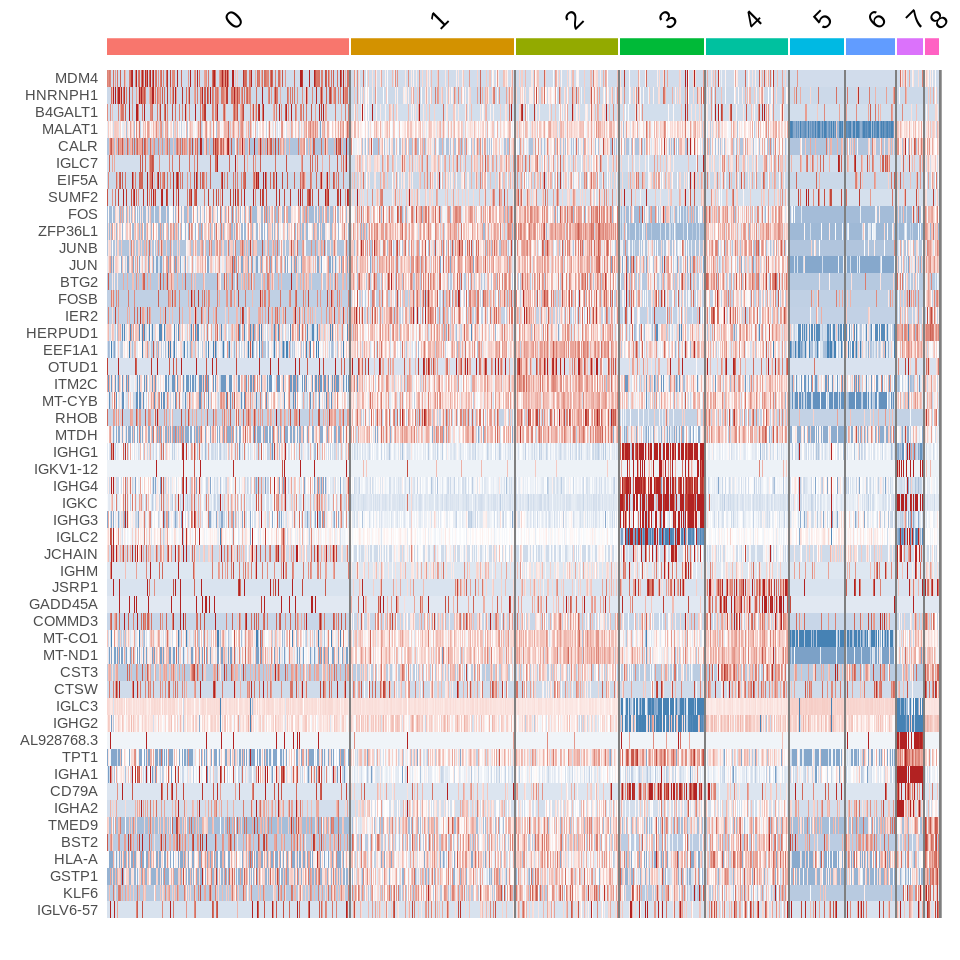

In [64]:
top10 <- plasma.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_log2FC)
DoHeatmap(plasma, features = top10$gene) + NoLegend()+ scale_fill_gradientn(colors = c("steelblue", "white", "firebrick"))

In [73]:
save(plasma,file="0709-pALPC1-plasma.Rda")

In [66]:
plasma

An object of class Seurat 
15284 features across 3675 samples within 1 assay 
Active assay: RNA (15284 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

In [67]:
options(repr.plot.height=9,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



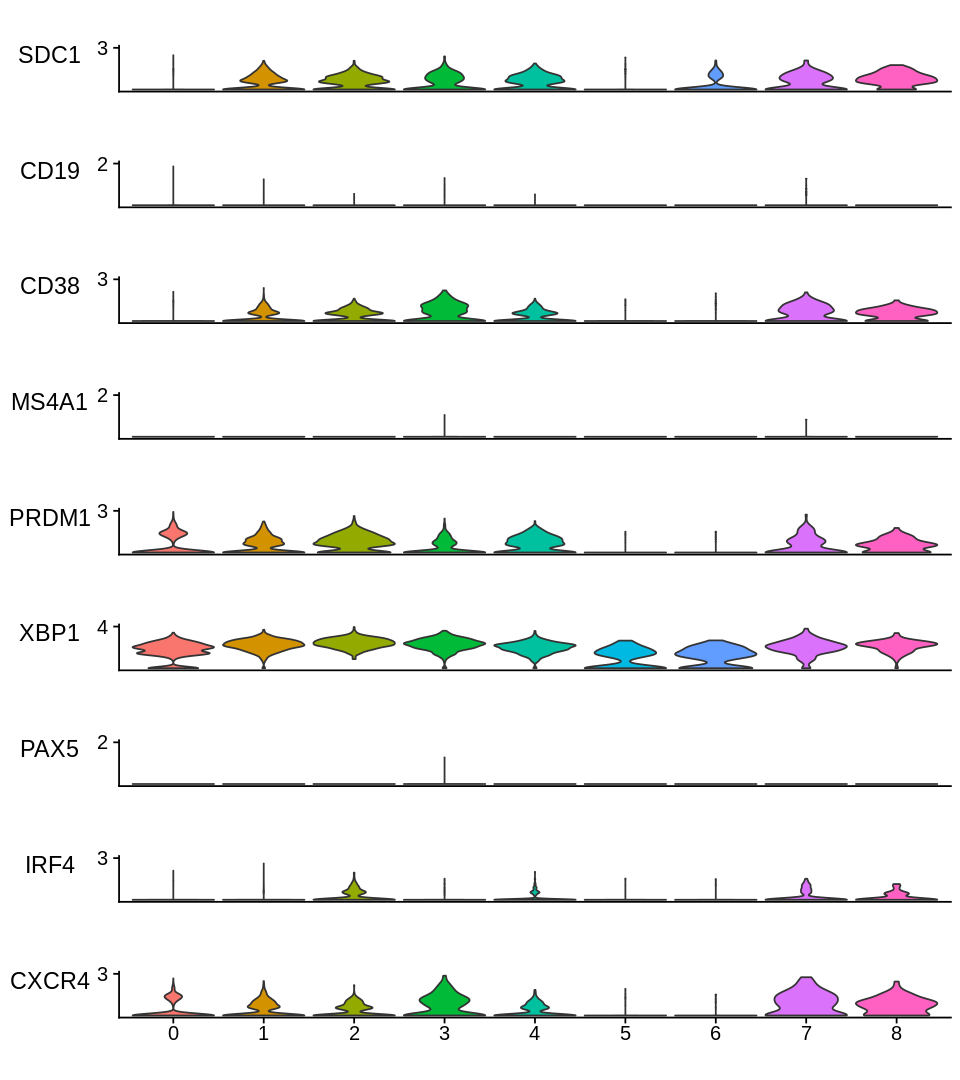

In [68]:
features<- c("SDC1","CD19","CD38","MS4A1","PRDM1","XBP1","PAX5","IRF4","CXCR4")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



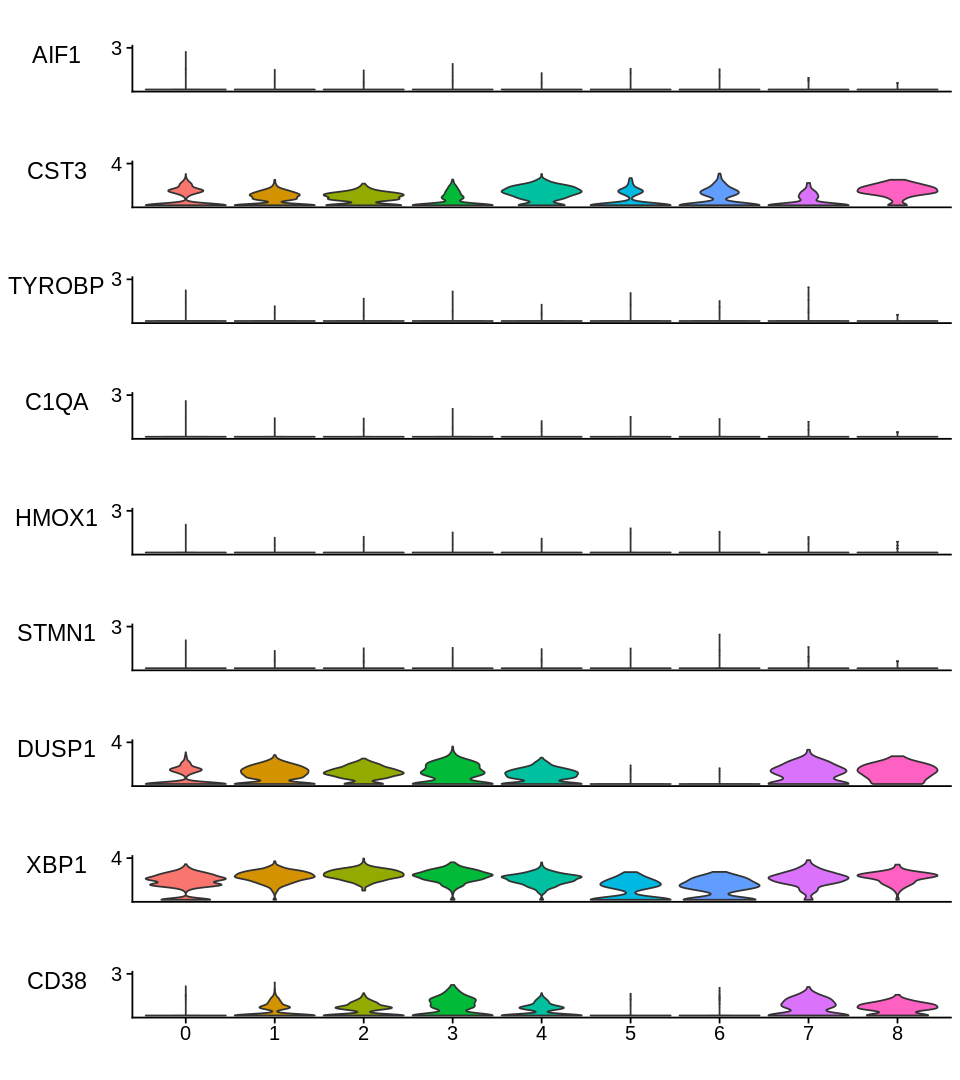

In [69]:
features<- c("AIF1","CST3","TYROBP","C1QA","HMOX1","STMN1","DUSP1","XBP1","CD38")
StackedVlnPlot(obj =plasma, features = features)

In [70]:
options(repr.plot.height=6,repr.plot.width=8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



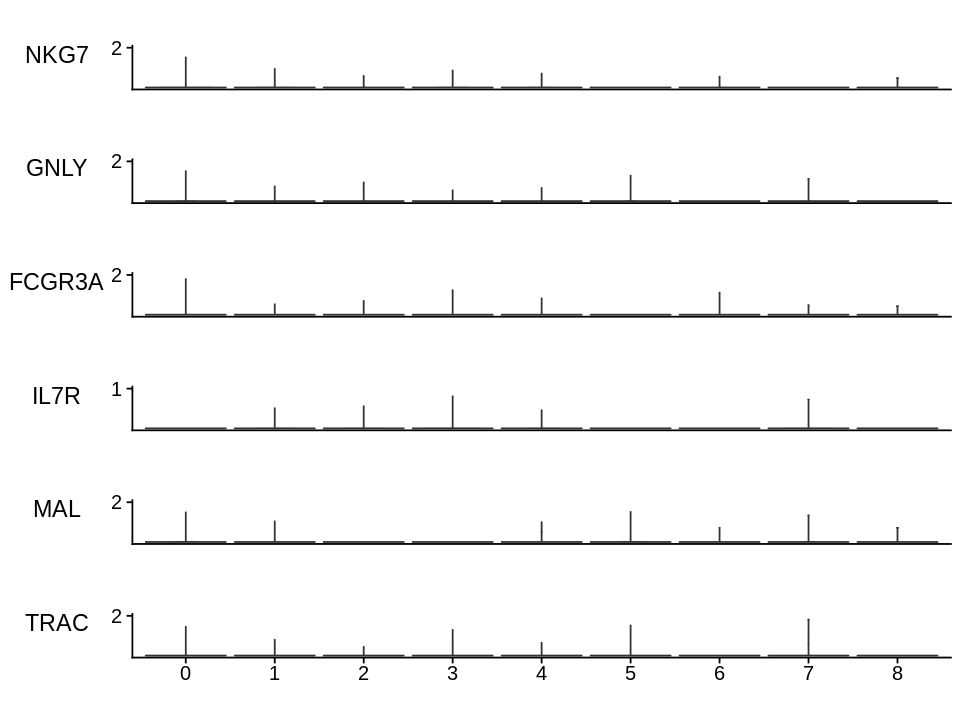

In [71]:
features<- c("NKG7","GNLY","FCGR3A","IL7R","MAL","TRAC")
StackedVlnPlot(obj =plasma, features = features)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



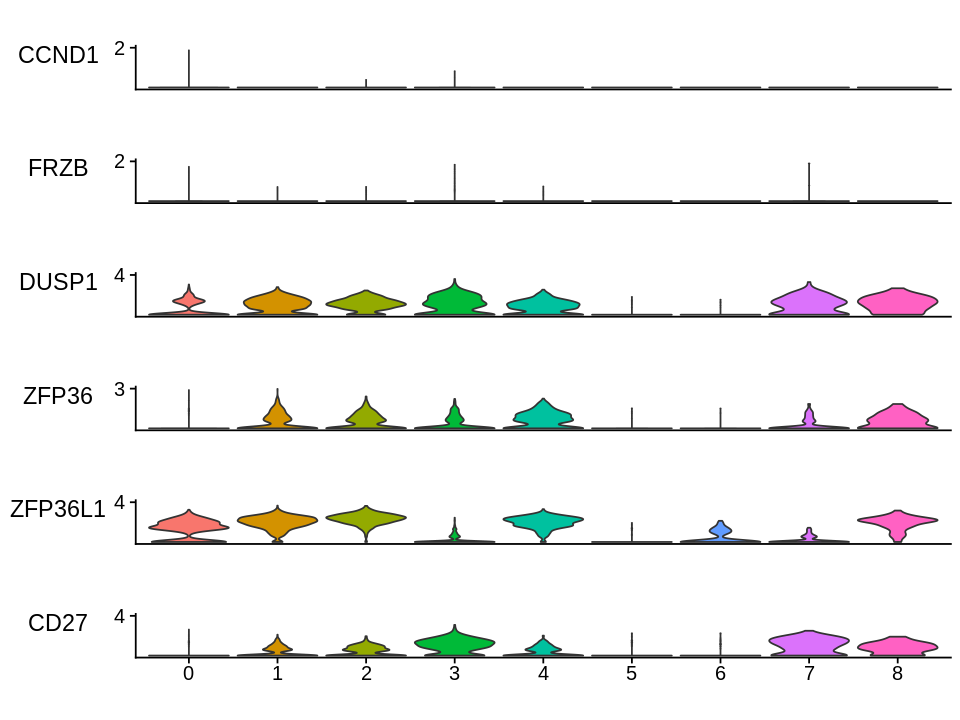

In [72]:
features<- c("CCND1","FRZB","DUSP1","ZFP36","ZFP36L1","CD27")
StackedVlnPlot(obj =plasma, features = features)